## Dependencies

In [1]:
import pandas as pd 
from CreditScoringToolkit import frequency_table
from CreditScoringToolkit import DiscreteNormalizer
from CreditScoringToolkit import WoeEncoder
from CreditScoringToolkit import WoeContinuousFeatureSelector
from CreditScoringToolkit import WoeDiscreteFeatureSelector
from CreditScoringToolkit import CreditScoring
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
import os

# 1. Block Python warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)

# 2. Block C-level/System warnings (The "Shut Up" flag)
os.environ['PYTHONWARNINGS'] = 'ignore'

pd.set_option('display.max_columns',None)

## Reading example data

In [2]:
data = pd.read_csv('../data/sme_mx.csv')
print(data.shape) 
data.head()

(885, 26)


,id,edadEmprendedor,sexoEmprendedor,escolaridadEmprendedor,dependientesEconomicos,estadoCivil,familiaAyuda,antiguedadNegocio,horaApertura,horaCierre,giroNegocio,numEmpleados,ventasPromedioDiarias,deseoNegocio,registroVentas,registroContabilidad,altaSAT,usaCredito,tiempoCreditoProveedores,promocionNegocio,latitud,longitud,CategoríaDeseo,Unnamed: 23,Respuesta Original,Categoría
0,E00000000,54,H,universidad trunca,3,casado,False,35.0,9,18,"servicios para el hogar (cerrajería, plomería,...",3,3500.0,eficacia,en un cuaderno,en un sistema especial,s,False,no me dan crédito,publicidad exterior|redes sociales (sin pagar)...,19.453446,-99.168899,Operación y Personal,NaN,venta,Ventas e Ingresos
1,E00000001,56,M,universidad terminado,2,viudo,False,37.0,8,15,comercio minorista de materias primas,3,4500.0,bodega,en excel,en excel,s,False,no me dan crédito,publicidad exterior|redes sociales (sin pagar),19.486575,-99.204668,Expansión y Estructura,NaN,cliente,Clientes y Promoción
2,E00000002,46,H,secundaria,5,casado,False,19.0,8,17,comercio minorista de materias primas,2,26250.0,ampliar negocio,en un sistema especial,en un sistema especial,s,False,una semana,publicidad exterior,19.451805,-99.191410,Expansión y Estructura,NaN,vender,Ventas e Ingresos
3,E00000003,49,H,bachillerato terminado,1,soltero,True,14.0,11,16,"servicios personales(estéticas, spa, uñas, ba...",0,1000.0,venta,en excel,en excel,s,True,no me dan crédito,publicidad exterior|redes sociales (sin pagar)...,19.452382,-99.186754,Ventas e Ingresos,NaN,sucursal,Expansión y Estructura
4,E00000004,47,H,universidad trunca,3,union libre,False,22.0,9,20,comercio minorista de materias primas,2,12000.0,aumentar capital trabajo,en un cuaderno,en excel,s,False,una semana,redes sociales (sin pagar),19.453695,-99.210195,Inversión y Producto,NaN,local,Expansión y Estructura


## Defining feature type

In [3]:
varc = [
    'edadEmprendedor', 'antiguedadNegocio', 'horaApertura', 
    'horaCierre', 'ventasPromedioDiarias','dependientesEconomicos', 'numEmpleados'
]

vard = [
     'sexoEmprendedor', 'escolaridadEmprendedor','estadoCivil', 'familiaAyuda', 
    'giroNegocio', 'deseoNegocio', 
    'registroVentas', 'registroContabilidad',  
    'usaCredito', 'tiempoCreditoProveedores', 'promocionNegocio', 
    'CategoríaDeseo', 'Categoría'
]

vart = ['altaSAT']

um = ['id']

In [4]:
frequency_table(data,vart)

**** Frequency Table for altaSAT ****

         Abs. Freq.  Rel. Freq.  Cum. Abs. Freq.  Cum. Rel. Freq.
altaSAT                                                          
n               398    0.449718              398         0.449718
o               107    0.120904              505         0.570621
s               380    0.429379              885         1.000000






In [5]:
data = data.loc[data[vart[0]]!='o'].reset_index(drop=True)
data[vart[0]] = (data[vart[0]]=='n').astype(int) #1->No , 0->Yes

In [6]:
frequency_table(data,vart)

**** Frequency Table for altaSAT ****

         Abs. Freq.  Rel. Freq.  Cum. Abs. Freq.  Cum. Rel. Freq.
altaSAT                                                          
0               380    0.488432              380         0.488432
1               398    0.511568              778         1.000000






## Standardizing data types

In [7]:
for v in varc:
    data[v] = pd.to_numeric(data[v],errors='coerce')

for v in vard:
    data[v] = data[v].fillna('MISSING').astype(str)



## Data Partition 

In [8]:
train,valid =  train_test_split(data[um+vart+varc+vard],train_size=0.7)
train.reset_index(drop=True,inplace=True)
valid.reset_index(drop=True,inplace=True)
train.shape,valid.shape

((544, 22), (234, 22))

## Normalize Discrete Features

In [9]:
#  In this example, we aggregate categories with less than 10% of relative frequency
#  into a new category called 'SMALL CATEGORIES', if new created category don't reach
#  given relative frequency threshold (10%) then the most frequent category is imputed.
#  All missing values are treatead as the separate category MISSING

dn = DiscreteNormalizer(normalization_threshold=0.1,default_category='SMALL CATEGORIES')
dn.fit(train[vard])
Xt = dn.transform(train[vard])
frequency_table(Xt,vard)

**** Frequency Table for sexoEmprendedor ****

                 Abs. Freq.  Rel. Freq.  Cum. Abs. Freq.  Cum. Rel. Freq.
sexoEmprendedor                                                          
H                       278    0.511029              278         0.511029
M                       266    0.488971              544         1.000000




**** Frequency Table for escolaridadEmprendedor ****

                        Abs. Freq.  Rel. Freq.  Cum. Abs. Freq.  \
escolaridadEmprendedor                                            
bachillerato terminado         136    0.250000              136   
bachillerato trunco             70    0.128676              206   
primaria                        57    0.104779              263   
secundaria                     199    0.365809              462   
universidad terminado           82    0.150735              544   

                        Cum. Rel. Freq.  
escolaridadEmprendedor                   
bachillerato terminado         0.250000  
bac

### Check if Normalization process didn't produce unary features

In [10]:
unary = [v for v in vard if Xt[v].nunique()==1]
unary

['usaCredito']

In [11]:
vard = [v for v in vard if v not in unary]

In [21]:
dn = DiscreteNormalizer(normalization_threshold=0.1,default_category='SMALL CATEGORIES')
dn.fit(train[vard])
Xt = dn.transform(train[vard])
frequency_table(Xt,vard)

**** Frequency Table for sexoEmprendedor ****

                 Abs. Freq.  Rel. Freq.  Cum. Abs. Freq.  Cum. Rel. Freq.
sexoEmprendedor                                                          
H                       278    0.511029              278         0.511029
M                       266    0.488971              544         1.000000




**** Frequency Table for escolaridadEmprendedor ****

                        Abs. Freq.  Rel. Freq.  Cum. Abs. Freq.  \
escolaridadEmprendedor                                            
bachillerato terminado         136    0.250000              136   
bachillerato trunco             70    0.128676              206   
primaria                        57    0.104779              263   
secundaria                     199    0.365809              462   
universidad terminado           82    0.150735              544   

                        Cum. Rel. Freq.  
escolaridadEmprendedor                   
bachillerato terminado         0.250000  
bac

## WoE Based Best Feature Selection

In [22]:
#   Now we proceed with feature selection, we have special classes for each type of feature (discrete,continuous)
#   Discrete feature selector uses the given iv_threshold to select the best features only.
#   For continuous feature selector, a variety of methods are available for selecting the best features , namely:
#    -uniform: only uses equal-width discretized bins, selects number of bins with best IV value.  
#    -quantile: only uses equal-frequency discretized bins, selects number of bins with best IV value 
#    -kmeans: only uses discretized bins created by a K-Means clustering, selects number of bins with best IV value 
#    -gaussian: only uses discretized bins created by a Gaussian Mixture, selects number of bins with best IV value
#    -dcc: stands for Discrete Competitive Combination, creates segments for all individual methods and then 
#          selects the best method and its corresponding best number of bins for each feature.
#    -dec: stands for Discrete Exhaustive Combination, creates segments for all individual methods and then 
#          selects the best number of bins for each feature including every feasible method.
#
#   One can configure IV threshold, minimun/maximum number of discretization bins, whether or not to keep only
#   strictly monotonic segments and the number of pooling threads used in order to speed computations. 


Xt = pd.concat([Xt,train[varc]],axis=1) #Merge continuous features matrix with the normalized discrete predictors Matrix

wcf = WoeContinuousFeatureSelector()
wdf = WoeDiscreteFeatureSelector()

#  Perform feature selection
wcf.fit(Xt[varc],train[vart[0]],
        max_bins=4,
        strictly_monotonic=True,
        iv_threshold=0.1,
        method='uniform',
        n_threads=20)

wdf.fit(Xt[vard],train[vart[0]],iv_threshold=0.1
)

#  Create new matrix with discrete and discretized best features 
Xt = pd.concat([wdf.transform(Xt[vard]),wcf.transform(Xt[varc])],axis=1)

features = list(Xt.columns)

#  Print selection results
print("Best continuous features: ", wcf.selected_features)
print("Best discrete features: ",wdf.selected_features)
print("Best Features selected: ",features)

Best continuous features:  [{'feature': 'disc_antiguedadNegocio_4_uniform', 'iv': 0.18489400904005004, 'relevant': True, 'root_feature': 'antiguedadNegocio', 'nbins': '4', 'method': 'uniform', 'selected': True}, {'feature': 'disc_numEmpleados_3_uniform', 'iv': 0.16610707677321468, 'relevant': True, 'root_feature': 'numEmpleados', 'nbins': '3', 'method': 'uniform', 'selected': True}]
Best discrete features:  {'registroVentas': 0.5770962870868349, 'registroContabilidad': 0.9496314057177144, 'tiempoCreditoProveedores': 0.17271606768888542, 'CategoríaDeseo': 0.12321840343387552}
Best Features selected:  ['registroVentas', 'registroContabilidad', 'tiempoCreditoProveedores', 'CategoríaDeseo', 'disc_antiguedadNegocio_4_uniform', 'disc_numEmpleados_3_uniform']


## WoE Transformation 

In [23]:
#  Weight of Evidence Transformation
we = WoeEncoder()
we.fit(Xt[features],train[vart[0]])
Xwt = we.transform(Xt[features])
Xwt.head()

,registroVentas,registroContabilidad,tiempoCreditoProveedores,CategoríaDeseo,disc_antiguedadNegocio_4_uniform,disc_numEmpleados_3_uniform
0,-0.085715,-0.268813,-0.463317,-0.067331,-0.305363,-0.060162
1,-0.85473,-1.155791,-0.090252,0.248522,-0.305363,-0.060162
2,-0.085715,-0.268813,-0.090252,-0.067331,-0.305363,-0.060162
3,-0.085715,-0.268813,-0.090252,0.479046,-0.305363,-0.060162
4,-0.085715,-0.268813,-0.090252,-0.067331,-0.305363,-0.060162


## Logistic Regression Parameter Learning

In [24]:
lr = LogisticRegression()
lr.fit(Xwt,train[vart[0]])
print("AUC for training: ",roc_auc_score(y_score=lr.predict_proba(Xwt)[:,1],y_true=train[vart[0]]))

AUC for training:  0.8063610408237826


## Scoring

In [25]:
#  In order to perform the scoring transformation, we need the WoE encoded data, 
#  the WoeEncoder fitted object and the logistic regression fitter object 
#  to produce a nice formatted scorecard
cs = CreditScoring()
cs.fit(Xwt,we,lr)
cs.scorecard

points
feature                          attribute                     
CategoríaDeseo                   Clientes y Promoción        53
                                 Expansión y Estructura      66
                                 Gestión y Estabilidad       71
                                 SMALL CATEGORIES            76
                                 Ventas e Ingresos           65
disc_antiguedadNegocio_4_uniform (-inf, 14.002]              57
                                 (14.002, 28.001]            77
                                 (28.001, 42.001]            89
                                 (42.001, inf]              108
disc_numEmpleados_3_uniform      (-inf, 5.667]               66
                                 (11.333, inf]               68
                                 (5.667, 11.333]            113
registroContabilidad             en excel                   101
                                 en un cuaderno              59
                                 en un sistema especial     117
                                 no registro                 34
registroVentas                   en excel                    70
                                 en un cuaderno              66
                                 en un sistema especial      71
                                 no registro                 64
tiempoCreditoProveedores         SMALL CATEGORIES            85
                                 no contesto                 55
                                 no me dan crédito           64
                                 una semana                  83

## Validation

### Model Generalization

In [26]:
#  Applying all transformations to the validation data is now easy and straightforward
#  we can compute AUC to check model overfitting
Xv = pd.concat([wdf.transform(dn.transform(valid[vard])),wcf.transform(valid[varc])],axis=1)
Xwv = we.transform(Xv)
print("AUC for validation: ",roc_auc_score(y_score=lr.predict_proba(Xwv)[:,1],y_true=valid[vart[0]]))

AUC for validation:  0.7973555409452845


### Scoring Distributions

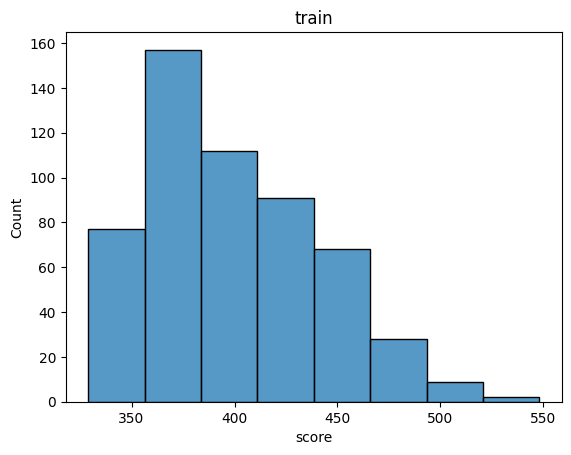

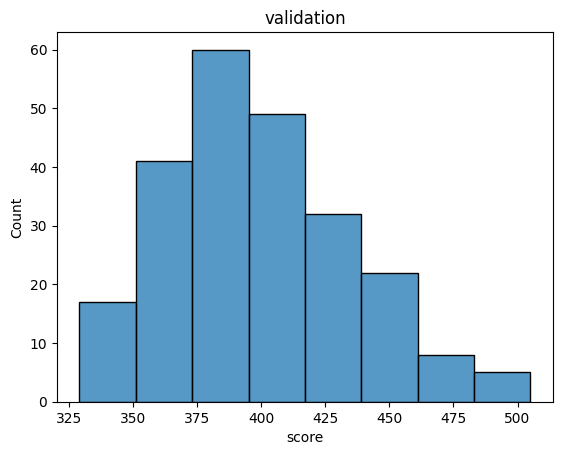

In [27]:
#  We can check the score transformation distributions for training and validation
score = pd.concat([pd.concat([cs.transform(we.inverse_transform(Xwv))[['score']].assign(sample='validation'),valid[vart[0]]],axis=1),
pd.concat([cs.transform(we.inverse_transform(Xwt))[['score']].assign(sample='train'),train[vart[0]]],axis=1)
                  ],ignore_index=True)

for s,d in score.groupby('sample'):
    plt.figure()
    plt.title(s)
    sns.histplot(d['score'],legend=True,fill=True,bins=8)

### Event rates

<Figure size 640x480 with 0 Axes>

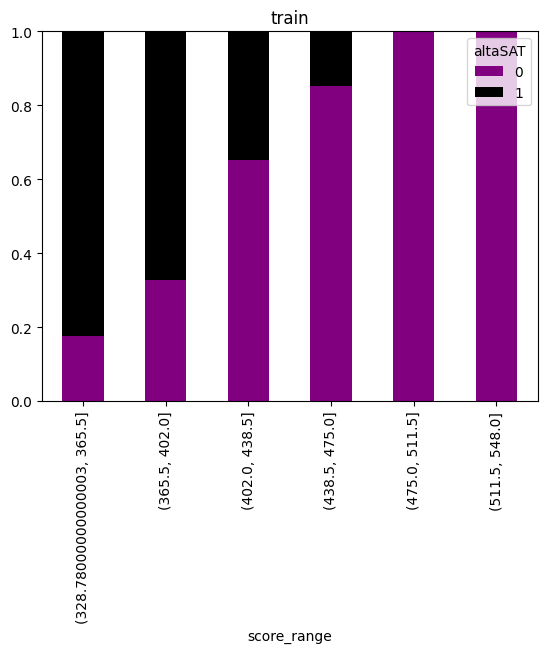

<Figure size 640x480 with 0 Axes>

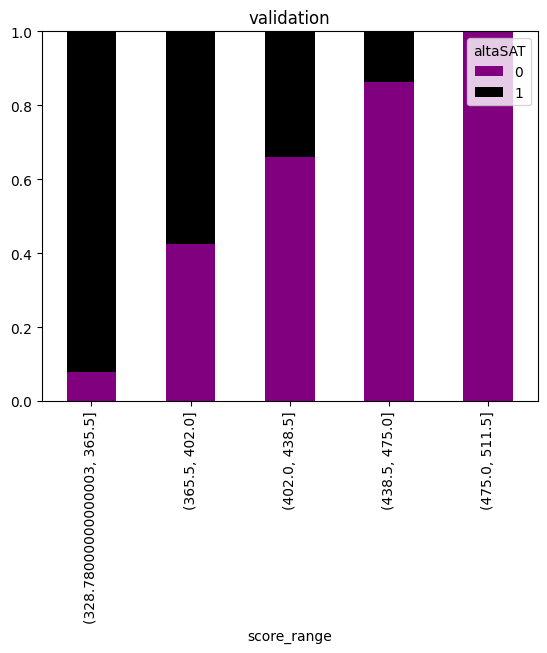

In [28]:
#   We can observe that, the greater the score, the lower the probability of being a 
#   bad customer (label=1) for both samples. Now all complexity is absorbed   
score['score_range'] = pd.cut(score['score'],bins=6,include_lowest=True).astype(str)
for s,d in score.groupby('sample'):
    aux = d.pivot_table(index=vart[0],
                        columns='score_range',
                        values='score',
                        aggfunc='count',
                        fill_value=0)
    aux/=aux.sum()
    aux = aux.T
    plt.figure()
    ax = aux.plot(kind='bar',stacked=True,color=['purple','black'])
    plt.title(s)

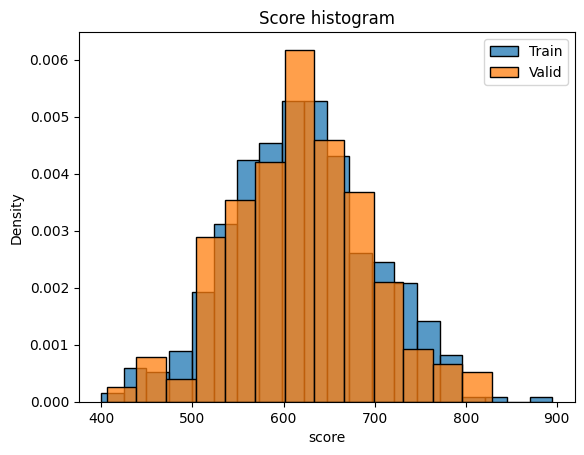

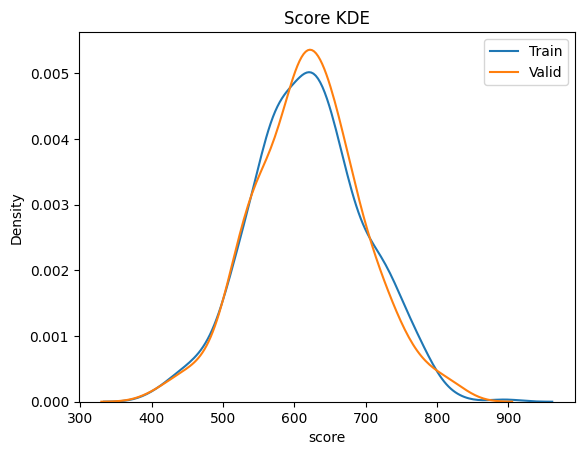

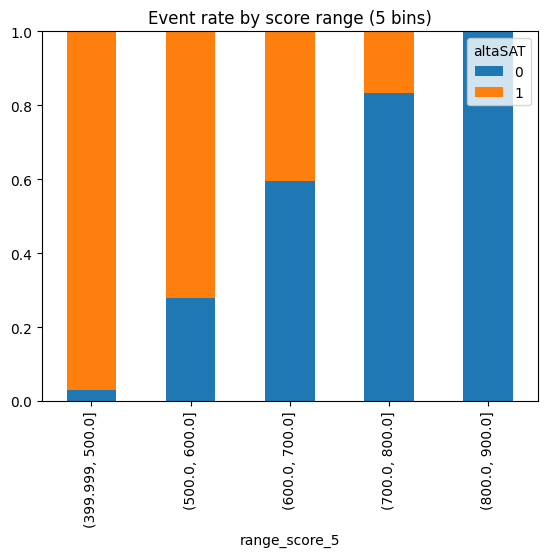

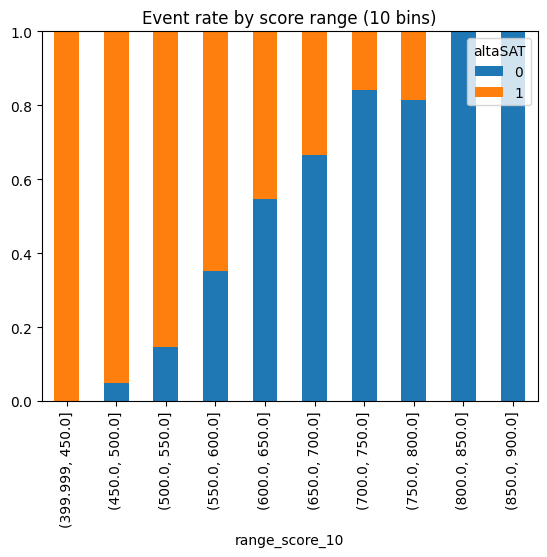

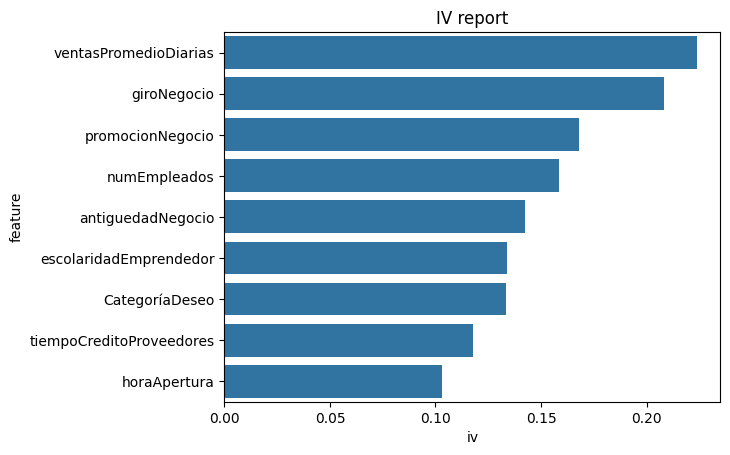

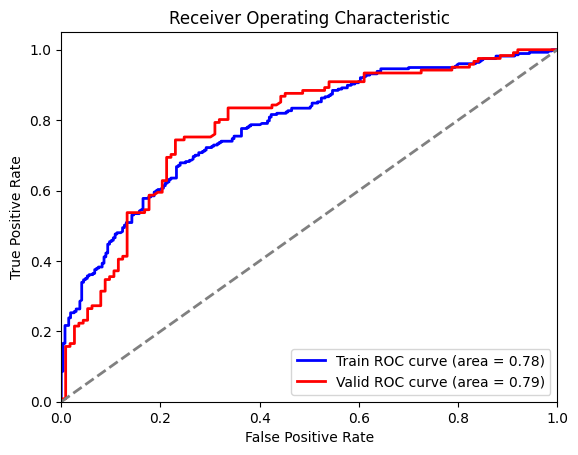

In [40]:
# If you prefer, use AutoCreditScoring class to perform all the steps in a single call with additional features
# like outlier detection and treatment, feature selection, reporting and more.
from CreditScoringToolkit import AutoCreditScoring

kwargs = {'iv_feature_threshold':0.1,
          'max_discretization_bins':4,
          'strictly_monotonic':True,
          'create_reporting':True,
          'discretization_method':'dcc',
          }
acs = AutoCreditScoring(data,vart[0],continuous_features=varc,discrete_features=[v for v in vard if v not in ['registroContabilidad','registroVentas']])
acs.fit(**kwargs)

# You can also save the reports to a folder in PNG format
acs.save_reports('reports')


In [41]:
acs.predict(valid).head()

,pts_antiguedadNegocio,pts_horaApertura,pts_numEmpleados,pts_ventasPromedioDiarias,pts_escolaridadEmprendedor,pts_giroNegocio,pts_tiempoCreditoProveedores,pts_promocionNegocio,pts_CategoríaDeseo,score,range_score_5,range_score_10
0,48,29,57,45,73,125,59,36,76,548.0,"(500.0, 600.0]","(500.0, 550.0]"
1,48,80,83,92,78,27,87,59,57,611.0,"(600.0, 700.0]","(600.0, 650.0]"
2,48,80,57,45,90,104,59,59,43,585.0,"(500.0, 600.0]","(550.0, 600.0]"
3,94,80,83,45,90,15,59,62,43,571.0,"(500.0, 600.0]","(550.0, 600.0]"
4,94,80,57,45,50,43,66,59,57,551.0,"(500.0, 600.0]","(550.0, 600.0]"


In [51]:
#aux = pd.concat([acs.predict(valid),valid[vart].assign(n=1)],axis=1)
aux[['range_score_5','n']+vart].groupby(['range_score_5']+vart).count().to_clipboard()

In [48]:
aux.head()

,pts_antiguedadNegocio,pts_horaApertura,pts_numEmpleados,pts_ventasPromedioDiarias,pts_escolaridadEmprendedor,pts_giroNegocio,pts_tiempoCreditoProveedores,pts_promocionNegocio,pts_CategoríaDeseo,score,range_score_5,range_score_10,altaSAT,n
0,48,29,57,45,73,125,59,36,76,548.0,"(500.0, 600.0]","(500.0, 550.0]",NaN,NaN
1,48,80,83,92,78,27,87,59,57,611.0,"(600.0, 700.0]","(600.0, 650.0]",NaN,NaN
2,48,80,57,45,90,104,59,59,43,585.0,"(500.0, 600.0]","(550.0, 600.0]",NaN,NaN
3,94,80,83,45,90,15,59,62,43,571.0,"(500.0, 600.0]","(550.0, 600.0]",NaN,NaN
4,94,80,57,45,50,43,66,59,57,551.0,"(500.0, 600.0]","(550.0, 600.0]",NaN,NaN


In [52]:
acs.credit_scoring.scorecard.to_clipboard()

## IV Calculator Example

In [42]:
from CreditScoringToolkit import IVCalculator

# Initialize IVCalculator with the training data
iv_calculator = IVCalculator(
    data=train,
    target=vart[0],
    continuous_features=varc,
    discrete_features=vard
)

# Calculate IV
iv_report = iv_calculator.calculate_iv(
    max_discretization_bins=5,
    strictly_monotonic=False,
    discretization_method='quantile',
    discrete_normalization_threshold=0.05
)

iv_report

,feature,iv,feature_type
0,registroContabilidad,0.949631,discrete
1,registroVentas,0.577096,discrete
2,ventasPromedioDiarias,0.347316,continuous
3,antiguedadNegocio,0.253369,continuous
4,tiempoCreditoProveedores,0.226212,discrete
5,numEmpleados,0.215793,continuous
6,giroNegocio,0.212224,discrete
7,CategoríaDeseo,0.149617,discrete
8,escolaridadEmprendedor,0.122789,discrete
9,promocionNegocio,0.115266,discrete
